In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer


In [4]:
df = pd.read_csv("StudentsPerformance.csv")

In [5]:
df.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
df.shape

(1000, 8)

In [7]:
print(df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [8]:
print(df.duplicated().sum())


0


In [9]:
numeric_cols = ["math score", "reading score", "writing score"]
df_clean = df.copy()

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

print("Outliers removed successfully!")
print("Original shape:", df.shape)
print("After outlier removal:", df_clean.shape)

Outliers removed successfully!
Original shape: (1000, 8)
After outlier removal: (986, 8)


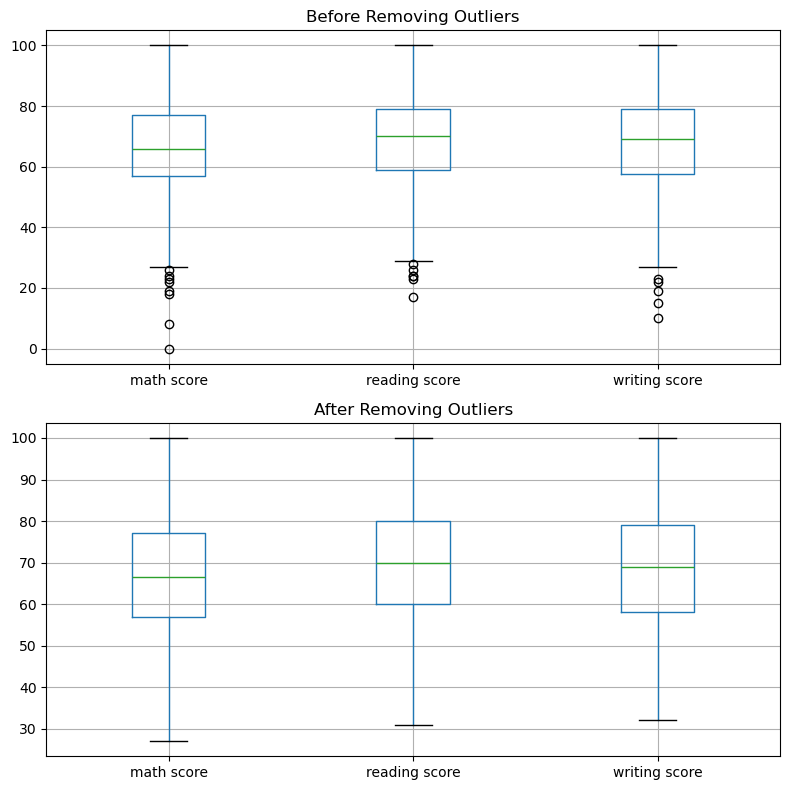

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8,8))
df[numeric_cols].boxplot(ax=axes[0])
axes[0].set_title("Before Removing Outliers")

df_clean[numeric_cols].boxplot(ax=axes[1])
axes[1].set_title("After Removing Outliers")

plt.tight_layout()
plt.show()


Skewness of numerical columns:
 math score      -0.025974
reading score   -0.077671
writing score   -0.084362
dtype: float64


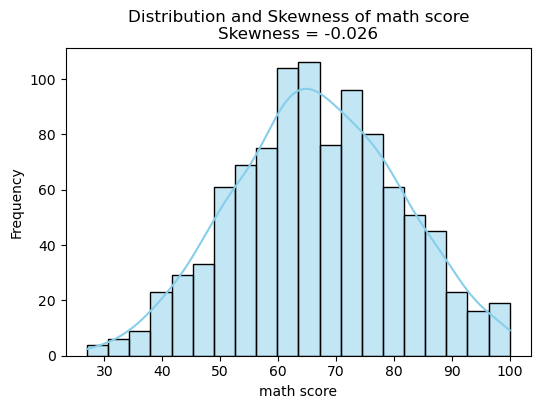

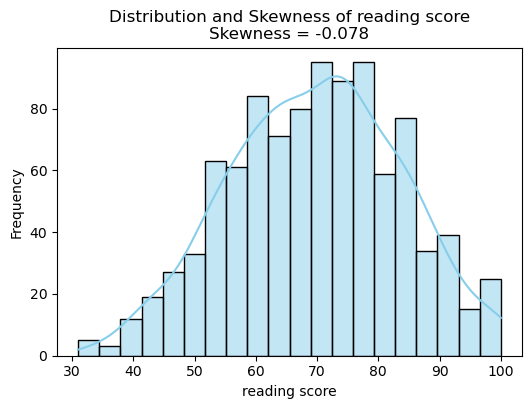

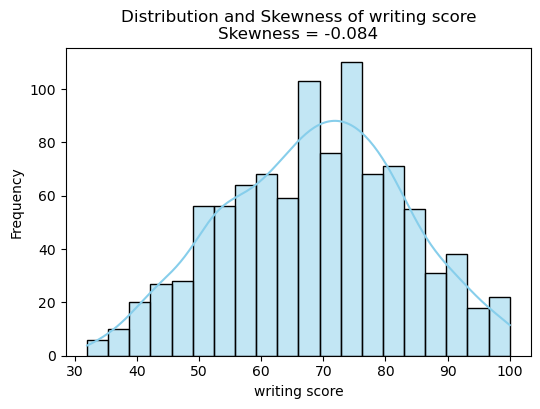

In [11]:

columns = ['math score', 'reading score', 'writing score']

skew_values = df_clean[columns].skew()
print("Skewness of numerical columns:\n", skew_values)

for col in columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df_clean[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution and Skewness of {col}\nSkewness = {skew_values[col]:.3f}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_clean['gender_num'] = le.fit_transform(df_clean['gender'])
df_clean['lunch_num'] = le.fit_transform(df_clean['lunch'])
df_clean['test_prep_num'] = le.fit_transform(df_clean['test preparation course'])
df_clean['parent_edu_num'] = le.fit_transform(df_clean['parental level of education'])


In [13]:
df_clean.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender_num,lunch_num,test_prep_num,parent_edu_num
0,female,group B,bachelor's degree,standard,none,72,72,74,0,1,1,1
1,female,group C,some college,standard,completed,69,90,88,0,1,0,4
2,female,group B,master's degree,standard,none,90,95,93,0,1,1,3
3,male,group A,associate's degree,free/reduced,none,47,57,44,1,0,1,0
4,male,group C,some college,standard,none,76,78,75,1,1,1,4


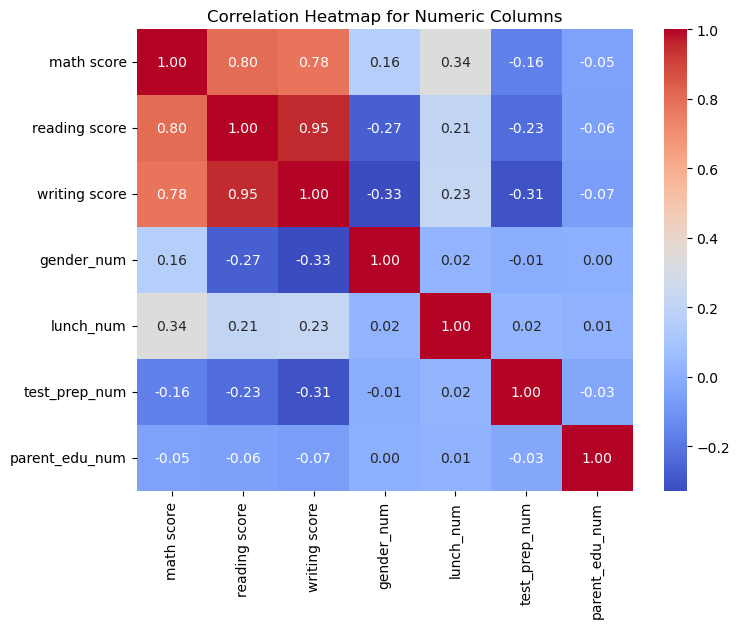

In [14]:
num_df = df_clean.select_dtypes(include=["number"])
corr = num_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap for Numeric Columns")
plt.show()


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

race_encoded = pd.get_dummies(df_clean['race/ethnicity'], prefix='race', drop_first=True)
X = pd.concat([race_encoded, df_clean[['gender_num', 'lunch_num', 'test_prep_num', 'parent_edu_num']]], axis=1)
y = df_clean['math score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

coeff_table = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
})

print("Intercept:", model.intercept_)
print("\nFeature Coefficients:")
print(coeff_table)
print("\nR² Score:", r2)
print("Mean Squared Error:", mse)


Intercept: 57.8296706933791

Feature Coefficients:
          Feature  Coefficient
0    race_group B     1.695933
1    race_group C     2.400232
2    race_group D     4.242341
3    race_group E     9.485508
4      gender_num     4.371063
5       lunch_num     9.719548
6   test_prep_num    -4.236024
7  parent_edu_num    -0.195552

R² Score: 0.2905248935610387
Mean Squared Error: 154.07010924842712


In [16]:
new_student = pd.DataFrame({
    'race_group B': [1], 
    'race_group C': [0],
    'race_group D': [0],
    'race_group E': [0],
    'gender_num': [0],     
    'lunch_num': [1],       
    'test_prep_num': [1],   
    'parent_edu_num': [5]   
})
predicted_math = model.predict(new_student)[0]

print(f"Predicted Math Score for new student: {predicted_math:.2f}")


Predicted Math Score for new student: 64.03


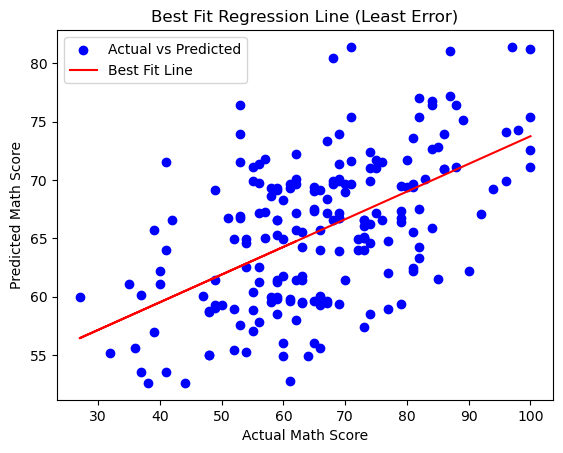

In [17]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')

m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Best Fit Line')

plt.xlabel("Actual Math Score")
plt.ylabel("Predicted Math Score")
plt.title("Best Fit Regression Line (Least Error)")
plt.legend()
plt.show()


In [18]:
import pickle

with open("trained_model.sav", "wb") as f:
    pickle.dump(model, f)
